### **Import necessary libraries**

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, f1_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.model_selection import cross_val_score
from joblib import dump
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
np.set_printoptions(suppress=True)

### **Load the data**

In [2]:
df_customers = pd.read_csv("data/customers.csv")
df_loans = pd.read_csv("data/loans.csv")
df_bureau = pd.read_csv("data/bureau_data.csv")

In [3]:
df_customers.shape, df_loans.shape, df_bureau.shape

((50000, 12), (50000, 15), (50000, 8))

In [4]:
df_customers.head()

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode
0,C00001,44,M,Married,Self-Employed,2586000,3,Owned,27,Delhi,Delhi,110001
1,C00002,38,M,Married,Salaried,1206000,3,Owned,4,Chennai,Tamil Nadu,600001
2,C00003,46,F,Married,Self-Employed,2878000,3,Owned,24,Kolkata,West Bengal,700001
3,C00004,55,F,Single,Self-Employed,3547000,1,Owned,15,Bangalore,Karnataka,560001
4,C00005,37,M,Married,Salaried,3432000,3,Owned,28,Pune,Maharashtra,411001


In [5]:
df_loans.head()

,loan_id,cust_id,loan_purpose,loan_type,sanction_amount,loan_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,disbursal_date,installment_start_dt,default
0,L00001,C00001,Auto,Secured,3004000,2467000,49340.00,444060,1973600,33,1630408,873386,2019-07-24,2019-08-10,False
1,L00002,C00002,Home,Secured,4161000,3883000,77660.00,698940,3106400,30,709309,464100,2019-07-24,2019-08-15,False
2,L00003,C00003,Personal,Unsecured,2401000,2170000,43400.00,390600,1736000,21,1562399,1476042,2019-07-24,2019-08-21,False
3,L00004,C00004,Personal,Unsecured,2345000,1747000,34940.00,314460,1397600,6,1257839,1031094,2019-07-24,2019-08-09,False
4,L00005,C00005,Auto,Secured,4647000,4520000,90400.00,813600,3616000,28,1772334,1032458,2019-07-24,2019-08-02,False


In [6]:
df = pd.merge(df_customers, df_loans, on='cust_id')
df.head()

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,...,loan_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,disbursal_date,installment_start_dt,default
0,C00001,44,M,Married,Self-Employed,2586000,3,Owned,27,Delhi,...,2467000,49340.00,444060,1973600,33,1630408,873386,2019-07-24,2019-08-10,False
1,C00002,38,M,Married,Salaried,1206000,3,Owned,4,Chennai,...,3883000,77660.00,698940,3106400,30,709309,464100,2019-07-24,2019-08-15,False
2,C00003,46,F,Married,Self-Employed,2878000,3,Owned,24,Kolkata,...,2170000,43400.00,390600,1736000,21,1562399,1476042,2019-07-24,2019-08-21,False
3,C00004,55,F,Single,Self-Employed,3547000,1,Owned,15,Bangalore,...,1747000,34940.00,314460,1397600,6,1257839,1031094,2019-07-24,2019-08-09,False
4,C00005,37,M,Married,Salaried,3432000,3,Owned,28,Pune,...,4520000,90400.00,813600,3616000,28,1772334,1032458,2019-07-24,2019-08-02,False


In [7]:
df = pd.merge(df, df_bureau, on='cust_id')
df.head()

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,...,disbursal_date,installment_start_dt,default,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio
0,C00001,44,M,Married,Self-Employed,2586000,3,Owned,27,Delhi,...,2019-07-24,2019-08-10,False,1,1,42,0,0,3,7
1,C00002,38,M,Married,Salaried,1206000,3,Owned,4,Chennai,...,2019-07-24,2019-08-15,False,3,1,96,12,60,5,4
2,C00003,46,F,Married,Self-Employed,2878000,3,Owned,24,Kolkata,...,2019-07-24,2019-08-21,False,2,1,82,24,147,6,58
3,C00004,55,F,Single,Self-Employed,3547000,1,Owned,15,Bangalore,...,2019-07-24,2019-08-09,False,3,0,115,15,87,5,26
4,C00005,37,M,Married,Salaried,3432000,3,Owned,28,Pune,...,2019-07-24,2019-08-02,False,4,2,120,0,0,5,10


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cust_id                      50000 non-null  object 
 1   age                          50000 non-null  int64  
 2   gender                       50000 non-null  object 
 3   marital_status               50000 non-null  object 
 4   employment_status            50000 non-null  object 
 5   income                       50000 non-null  int64  
 6   number_of_dependants         50000 non-null  int64  
 7   residence_type               49938 non-null  object 
 8   years_at_current_address     50000 non-null  int64  
 9   city                         50000 non-null  object 
 10  state                        50000 non-null  object 
 11  zipcode                      50000 non-null  int64  
 12  loan_id                      50000 non-null  object 
 13  loan_purpose    

In [9]:
df['default'] = df['default'].astype(int)
df.default.value_counts()

0    45703
1     4297
Name: default, dtype: int64

The target variable in this case is 'default', and there appears to be an imbalance in the class distribution. We will address this issue at a later stage.

### **Train test split**

To avoid data leakage, we conduct the train-test split before performing exploratory data analysis (EDA). This ensures that the test set, which is a subset of the overall dataset, does not impact our EDA findings or influence any feature engineering decisions.

In [10]:
X = df.drop("default", axis="columns")
y = df['default']

X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.25,random_state=42)

df_train = pd.concat([X_train, y_train], axis="columns")
df_test = pd.concat([X_test, y_test], axis="columns")

df_train.head()

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,...,disbursal_date,installment_start_dt,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio,default
12746,C12747,59,M,Married,Self-Employed,11327000,3,Owned,30,Hyderabad,...,2020-10-31,2020-11-11,4,2,152,20,118,4,36,0
32495,C32496,44,F,Single,Salaried,715000,0,Owned,27,Mumbai,...,2022-10-22,2022-10-27,3,1,160,10,62,5,5,0
43675,C43676,38,M,Single,Salaried,3195000,0,Mortgage,26,Chennai,...,2023-12-04,2023-12-29,1,1,54,12,67,4,0,0
9040,C09041,42,M,Married,Salaried,1500000,2,Mortgage,30,Bangalore,...,2020-06-18,2020-07-07,3,0,76,0,0,8,87,0
13077,C13078,58,M,Married,Self-Employed,1817000,4,Owned,29,Pune,...,2020-11-12,2020-12-07,1,2,60,0,0,1,71,0


### **Data Cleaning**

#### Handle Missing & Duplicate Values

In [11]:
df_train.shape

(37500, 33)

In [12]:
df_train.isna().sum()

cust_id                         0
age                             0
gender                          0
marital_status                  0
employment_status               0
income                          0
number_of_dependants            0
residence_type                 47
years_at_current_address        0
city                            0
state                           0
zipcode                         0
loan_id                         0
loan_purpose                    0
loan_type                       0
sanction_amount                 0
loan_amount                     0
processing_fee                  0
gst                             0
net_disbursement                0
loan_tenure_months              0
principal_outstanding           0
bank_balance_at_application     0
disbursal_date                  0
installment_start_dt            0
number_of_open_accounts         0
number_of_closed_accounts       0
total_loan_months               0
delinquent_months               0
total_dpd     

In [13]:
df_train.residence_type.unique()

array(['Owned', 'Mortgage', 'Rented', nan], dtype=object)

In [14]:
mode_residence = df_train.residence_type.mode()[0]
mode_residence

'Owned'

In [15]:
df_train.residence_type.fillna(mode_residence, inplace=True)
df_test.residence_type.fillna(mode_residence, inplace=True)

In [16]:
df_train.residence_type.unique(), df_test.residence_type.unique()

(array(['Owned', 'Mortgage', 'Rented'], dtype=object),
 array(['Owned', 'Mortgage', 'Rented'], dtype=object))

In [17]:
df_train.duplicated().sum()

0

In [18]:
df_train.describe()

,age,income,number_of_dependants,years_at_current_address,zipcode,sanction_amount,loan_amount,processing_fee,gst,net_disbursement,...,principal_outstanding,bank_balance_at_application,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio,default
count,37500.00,37500.00,37500.00,37500.00,37500.00,37500.00,37500.00,37500.00,37500.00,37500.00,...,37500.00,37500.00,37500.00,37500.00,37500.00,37500.00,37500.00,37500.00,37500.00,37500.00
mean,39.54,2633326.16,1.94,16.00,418866.25,4699691.57,3996067.73,80290.68,719292.19,3196854.19,...,1333819.51,986298.87,2.50,1.00,76.11,4.84,26.67,5.01,43.42,0.09
std,9.86,2623780.52,1.54,8.92,169035.02,6257832.98,5371862.29,113128.14,966935.21,4297489.83,...,1213674.44,1043145.01,1.12,0.81,43.77,5.84,32.78,2.03,29.39,0.28
min,18.00,0.00,0.00,1.00,110001.00,0.00,0.00,0.00,0.00,0.00,...,-1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
25%,33.00,802000.00,0.00,8.00,302001.00,1142000.00,961000.00,19220.00,172980.00,768800.00,...,422197.50,287040.25,1.00,0.00,42.00,0.00,0.00,4.00,18.00,0.00
50%,39.00,1885000.00,2.00,16.00,400001.00,2644000.00,2230000.00,44600.00,401400.00,1784000.00,...,997427.50,665014.50,3.00,1.00,71.00,3.00,13.00,5.00,39.00,0.00
75%,46.00,3326250.00,3.00,24.00,560001.00,5178000.00,4619000.00,92420.00,831420.00,3695200.00,...,1784879.00,1234062.75,4.00,2.00,107.00,8.00,46.00,6.00,67.00,0.00
max,70.00,11999000.00,5.00,31.00,700001.00,52175000.00,47819000.00,5293543.52,8607420.00,38255200.00,...,5000000.00,7846643.00,4.00,2.00,223.00,24.00,171.00,9.00,99.00,1.00


In [19]:
df_train.columns

Index(['cust_id', 'age', 'gender', 'marital_status', 'employment_status',
       'income', 'number_of_dependants', 'residence_type',
       'years_at_current_address', 'city', 'state', 'zipcode', 'loan_id',
       'loan_purpose', 'loan_type', 'sanction_amount', 'loan_amount',
       'processing_fee', 'gst', 'net_disbursement', 'loan_tenure_months',
       'principal_outstanding', 'bank_balance_at_application',
       'disbursal_date', 'installment_start_dt', 'number_of_open_accounts',
       'number_of_closed_accounts', 'total_loan_months', 'delinquent_months',
       'total_dpd', 'enquiry_count', 'credit_utilization_ratio', 'default'],
      dtype='object')

In [20]:
columns_continuous = ['age', 'income', 'number_of_dependants', 'years_at_current_address', 
                      'sanction_amount', 'loan_amount', 'processing_fee', 'gst', 'net_disbursement', 
                      'loan_tenure_months','principal_outstanding', 'bank_balance_at_application',
                      'number_of_open_accounts','number_of_closed_accounts', 'total_loan_months', 'delinquent_months',
                       'total_dpd', 'enquiry_count', 'credit_utilization_ratio']

columns_categorical = ['gender', 'marital_status', 'employment_status', 'residence_type', 'city', 
                       'state', 'zipcode', 'loan_purpose', 'loan_type', 'default']

#### Box plot for visualize outliers

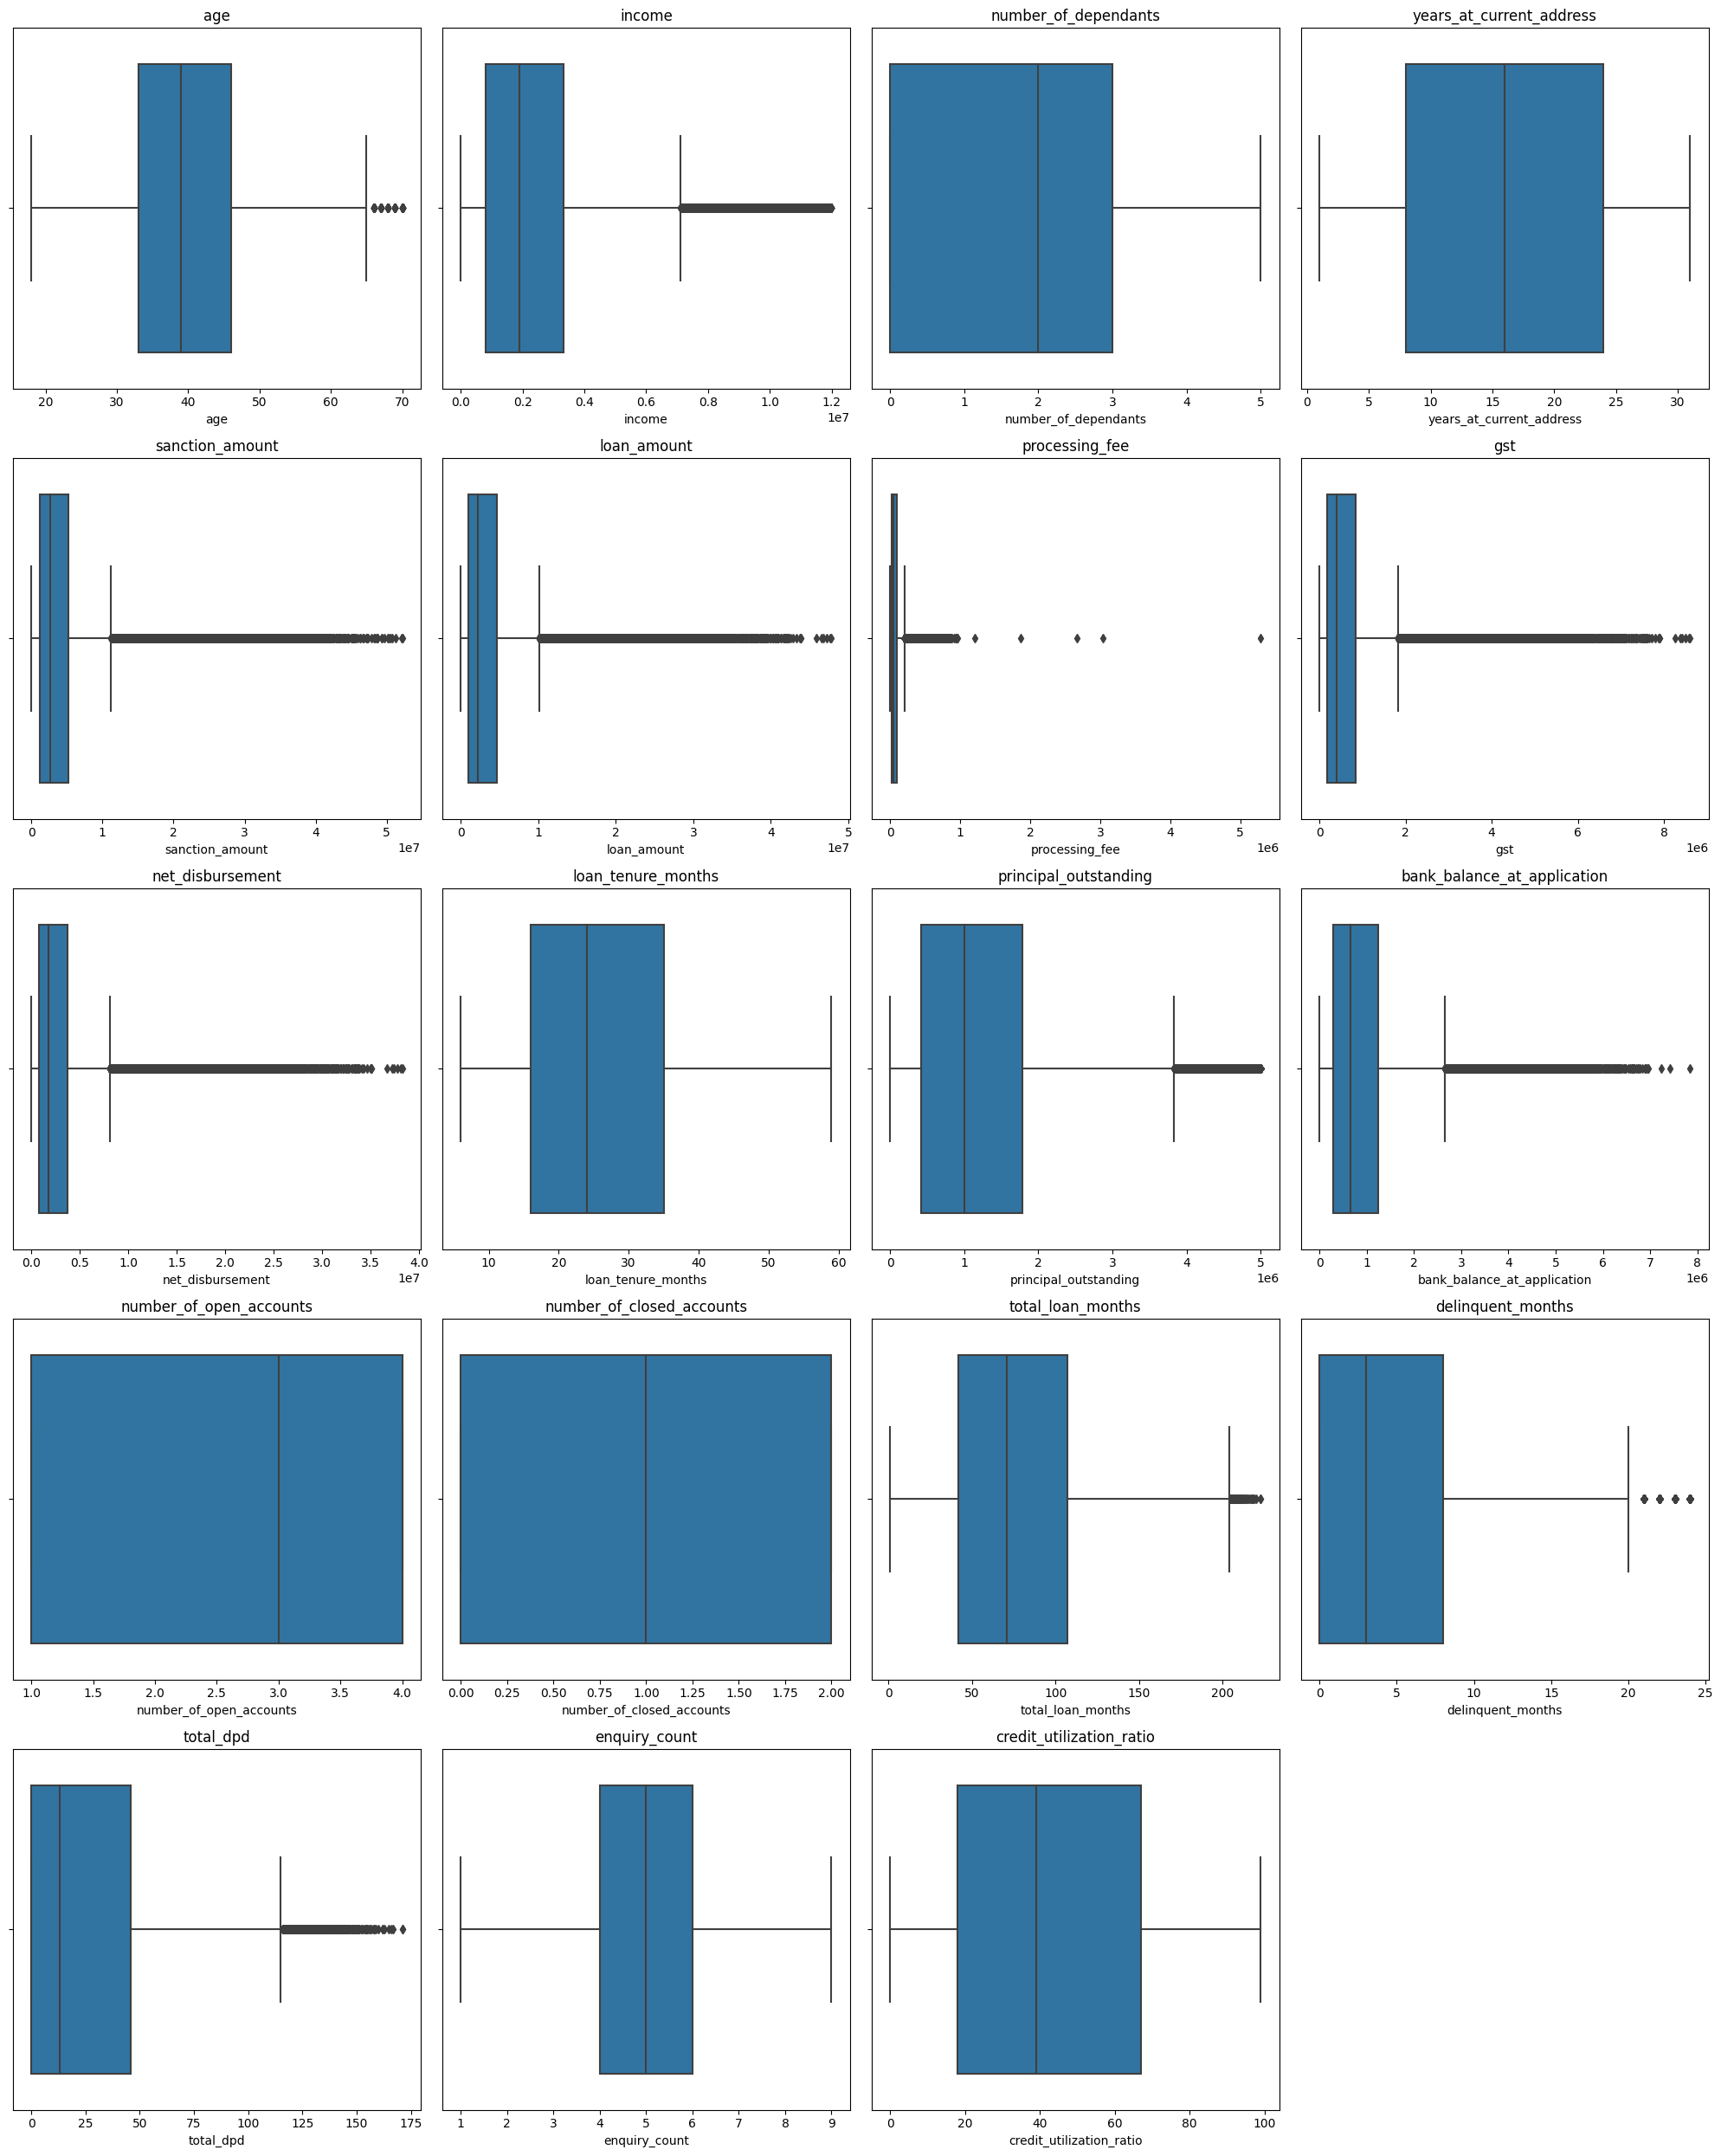

In [21]:
num_plots = len(columns_continuous)
num_cols = 4
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(columns_continuous):
    sns.boxplot(x=df_train[col], ax=axes[i])
    axes[i].set_title(col)

for j in range(i + 1, num_rows * num_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


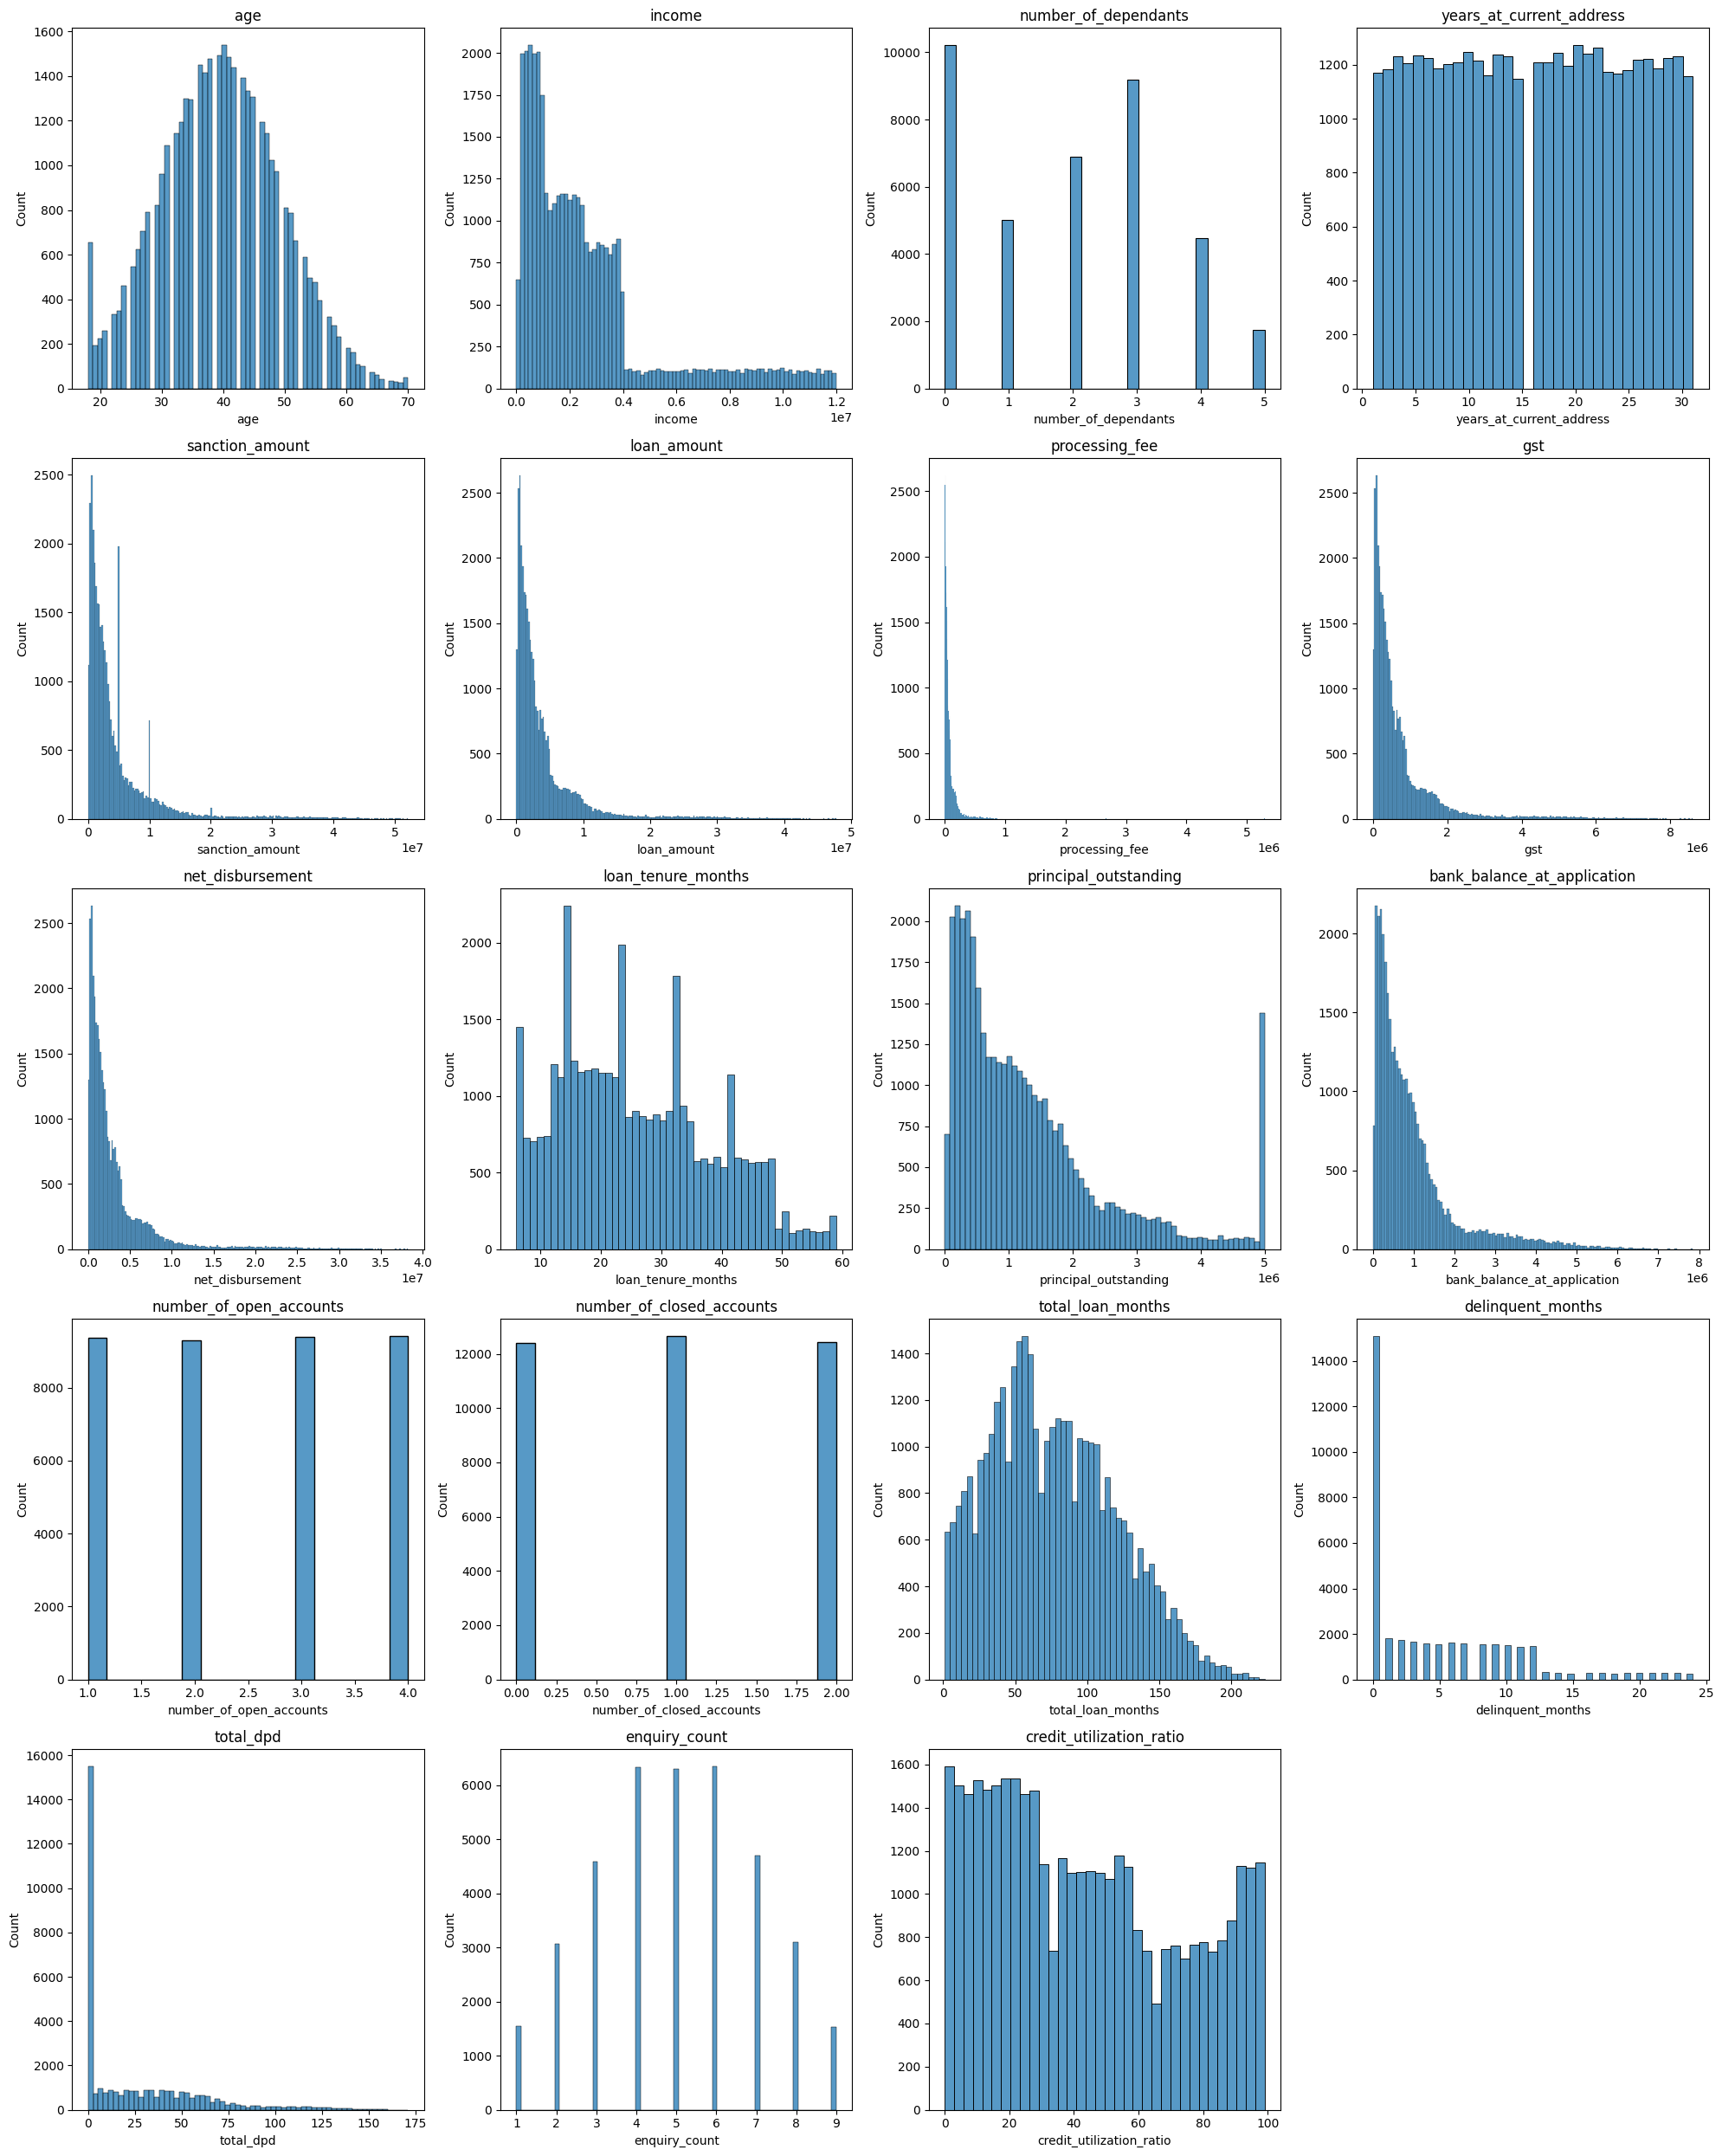

In [22]:
num_plots = len(columns_continuous)
num_cols = 4
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(columns_continuous):
    sns.histplot(df_train[col], ax=axes[i])
    axes[i].set_title(col)

for j in range(i + 1, num_rows * num_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


#### Outlier Removal: Processing Fee

In [23]:
df_train.processing_fee.describe()

count     37500.00
mean      80290.68
std      113128.14
min           0.00
25%       19220.00
50%       44600.00
75%       92420.00
max     5293543.52
Name: processing_fee, dtype: float64

In [24]:
df_train[(df_train.processing_fee/df_train.loan_amount)>0.03][["loan_amount","processing_fee"]]

,loan_amount,processing_fee
23981,2234000,2669791.02
28174,966000,1214492.67
47089,1738000,1858964.77
29305,2616000,3036378.01
9898,3626000,5293543.52


In [25]:
df_train_1 = df_train[df_train.processing_fee/df_train.loan_amount<0.03].copy()
df_train_1.shape

(37488, 33)

In [26]:
df_test.residence_type.isna().sum()

0

In [27]:
# Applying same step on test set

df_test = df_test[df_test.processing_fee/df_test.loan_amount<0.03].copy()
df_test.shape

(12497, 33)

In [28]:
# Use other business rules for data validation
# Rule 1: GST should not be more than 20%

df_train_1[(df_train_1.gst/df_train_1.loan_amount)>0.2].shape

(0, 33)

In [29]:
# Rule 2: Net disbursement should not be higher than loan_amount

df_train_1[df_train_1.net_disbursement>df_train_1.loan_amount].shape

(0, 33)

No records were identified that violate Rule 1 or Rule 2.

#### Analyze Categorical Columns

In [30]:
columns_categorical

['gender',
 'marital_status',
 'employment_status',
 'residence_type',
 'city',
 'state',
 'zipcode',
 'loan_purpose',
 'loan_type',
 'default']

In [31]:
for col in columns_categorical:
    print(col, "-->", df_train_1[col].unique())

gender --> ['M' 'F']
marital_status --> ['Married' 'Single']
employment_status --> ['Self-Employed' 'Salaried']
residence_type --> ['Owned' 'Mortgage' 'Rented']
city --> ['Hyderabad' 'Mumbai' 'Chennai' 'Bangalore' 'Pune' 'Kolkata' 'Ahmedabad'
 'Delhi' 'Lucknow' 'Jaipur']
state --> ['Telangana' 'Maharashtra' 'Tamil Nadu' 'Karnataka' 'West Bengal'
 'Gujarat' 'Delhi' 'Uttar Pradesh' 'Rajasthan']
zipcode --> [500001 400001 600001 560001 411001 700001 380001 110001 226001 302001]
loan_purpose --> ['Home' 'Education' 'Personal' 'Auto' 'Personaal']
loan_type --> ['Secured' 'Unsecured']
default --> [0 1]


#### Correct the errors present in the 'Loan Purpose' column.

In [32]:
df_train_1['loan_purpose'] = df_train_1['loan_purpose'].replace('Personaal', 'Personal')
df_train_1['loan_purpose'].unique()

array(['Home', 'Education', 'Personal', 'Auto'], dtype=object)

In [33]:
df_test['loan_purpose'] = df_test['loan_purpose'].replace('Personaal', 'Personal')
df_test['loan_purpose'].unique()

array(['Home', 'Education', 'Auto', 'Personal'], dtype=object)

### **Exploratory Data Analysis**

In [34]:
columns_continuous

['age',
 'income',
 'number_of_dependants',
 'years_at_current_address',
 'sanction_amount',
 'loan_amount',
 'processing_fee',
 'gst',
 'net_disbursement',
 'loan_tenure_months',
 'principal_outstanding',
 'bank_balance_at_application',
 'number_of_open_accounts',
 'number_of_closed_accounts',
 'total_loan_months',
 'delinquent_months',
 'total_dpd',
 'enquiry_count',
 'credit_utilization_ratio']

#### Age column

In [35]:
df_train_1.groupby("default")['age'].describe()

,count,mean,std,min,25%,50%,75%,max
default,,,,,,,,
0,34265.00,39.77,9.88,18.00,33.00,40.00,46.00,70.00
1,3223.00,37.12,9.29,18.00,31.00,37.00,44.00,70.00


**Insights**

1. The average age in the default group (37.12) is slightly lower than the average age in the non-default group (39.7).
2. The variability, measured by standard deviation, is fairly consistent across both groups.
3. Both groups share similar minimum and maximum age values.

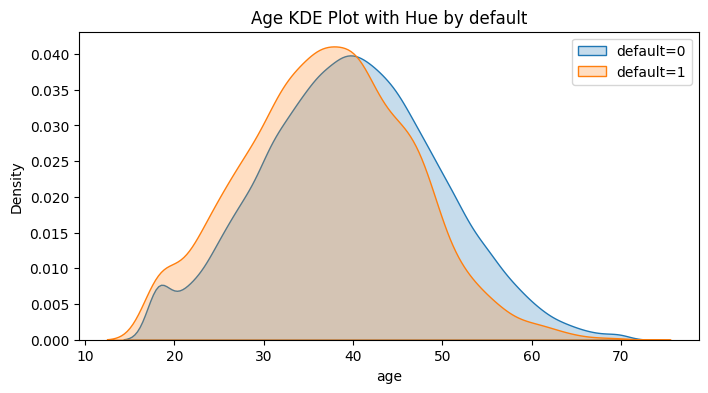

In [36]:
plt.figure(figsize=(8, 4))
sns.kdeplot(df_train_1['age'][df_train_1['default'] == 0], fill=True, label='default=0')
sns.kdeplot(df_train_1['age'][df_train_1['default'] == 1], fill=True, label='default=1')
plt.title(f"Age KDE Plot with Hue by default")
plt.legend()
plt.show()

**Insights**

1. The orange (defaulted) group is slightly shifted to the left, suggesting that younger individuals have a higher likelihood of defaulting on their loans.

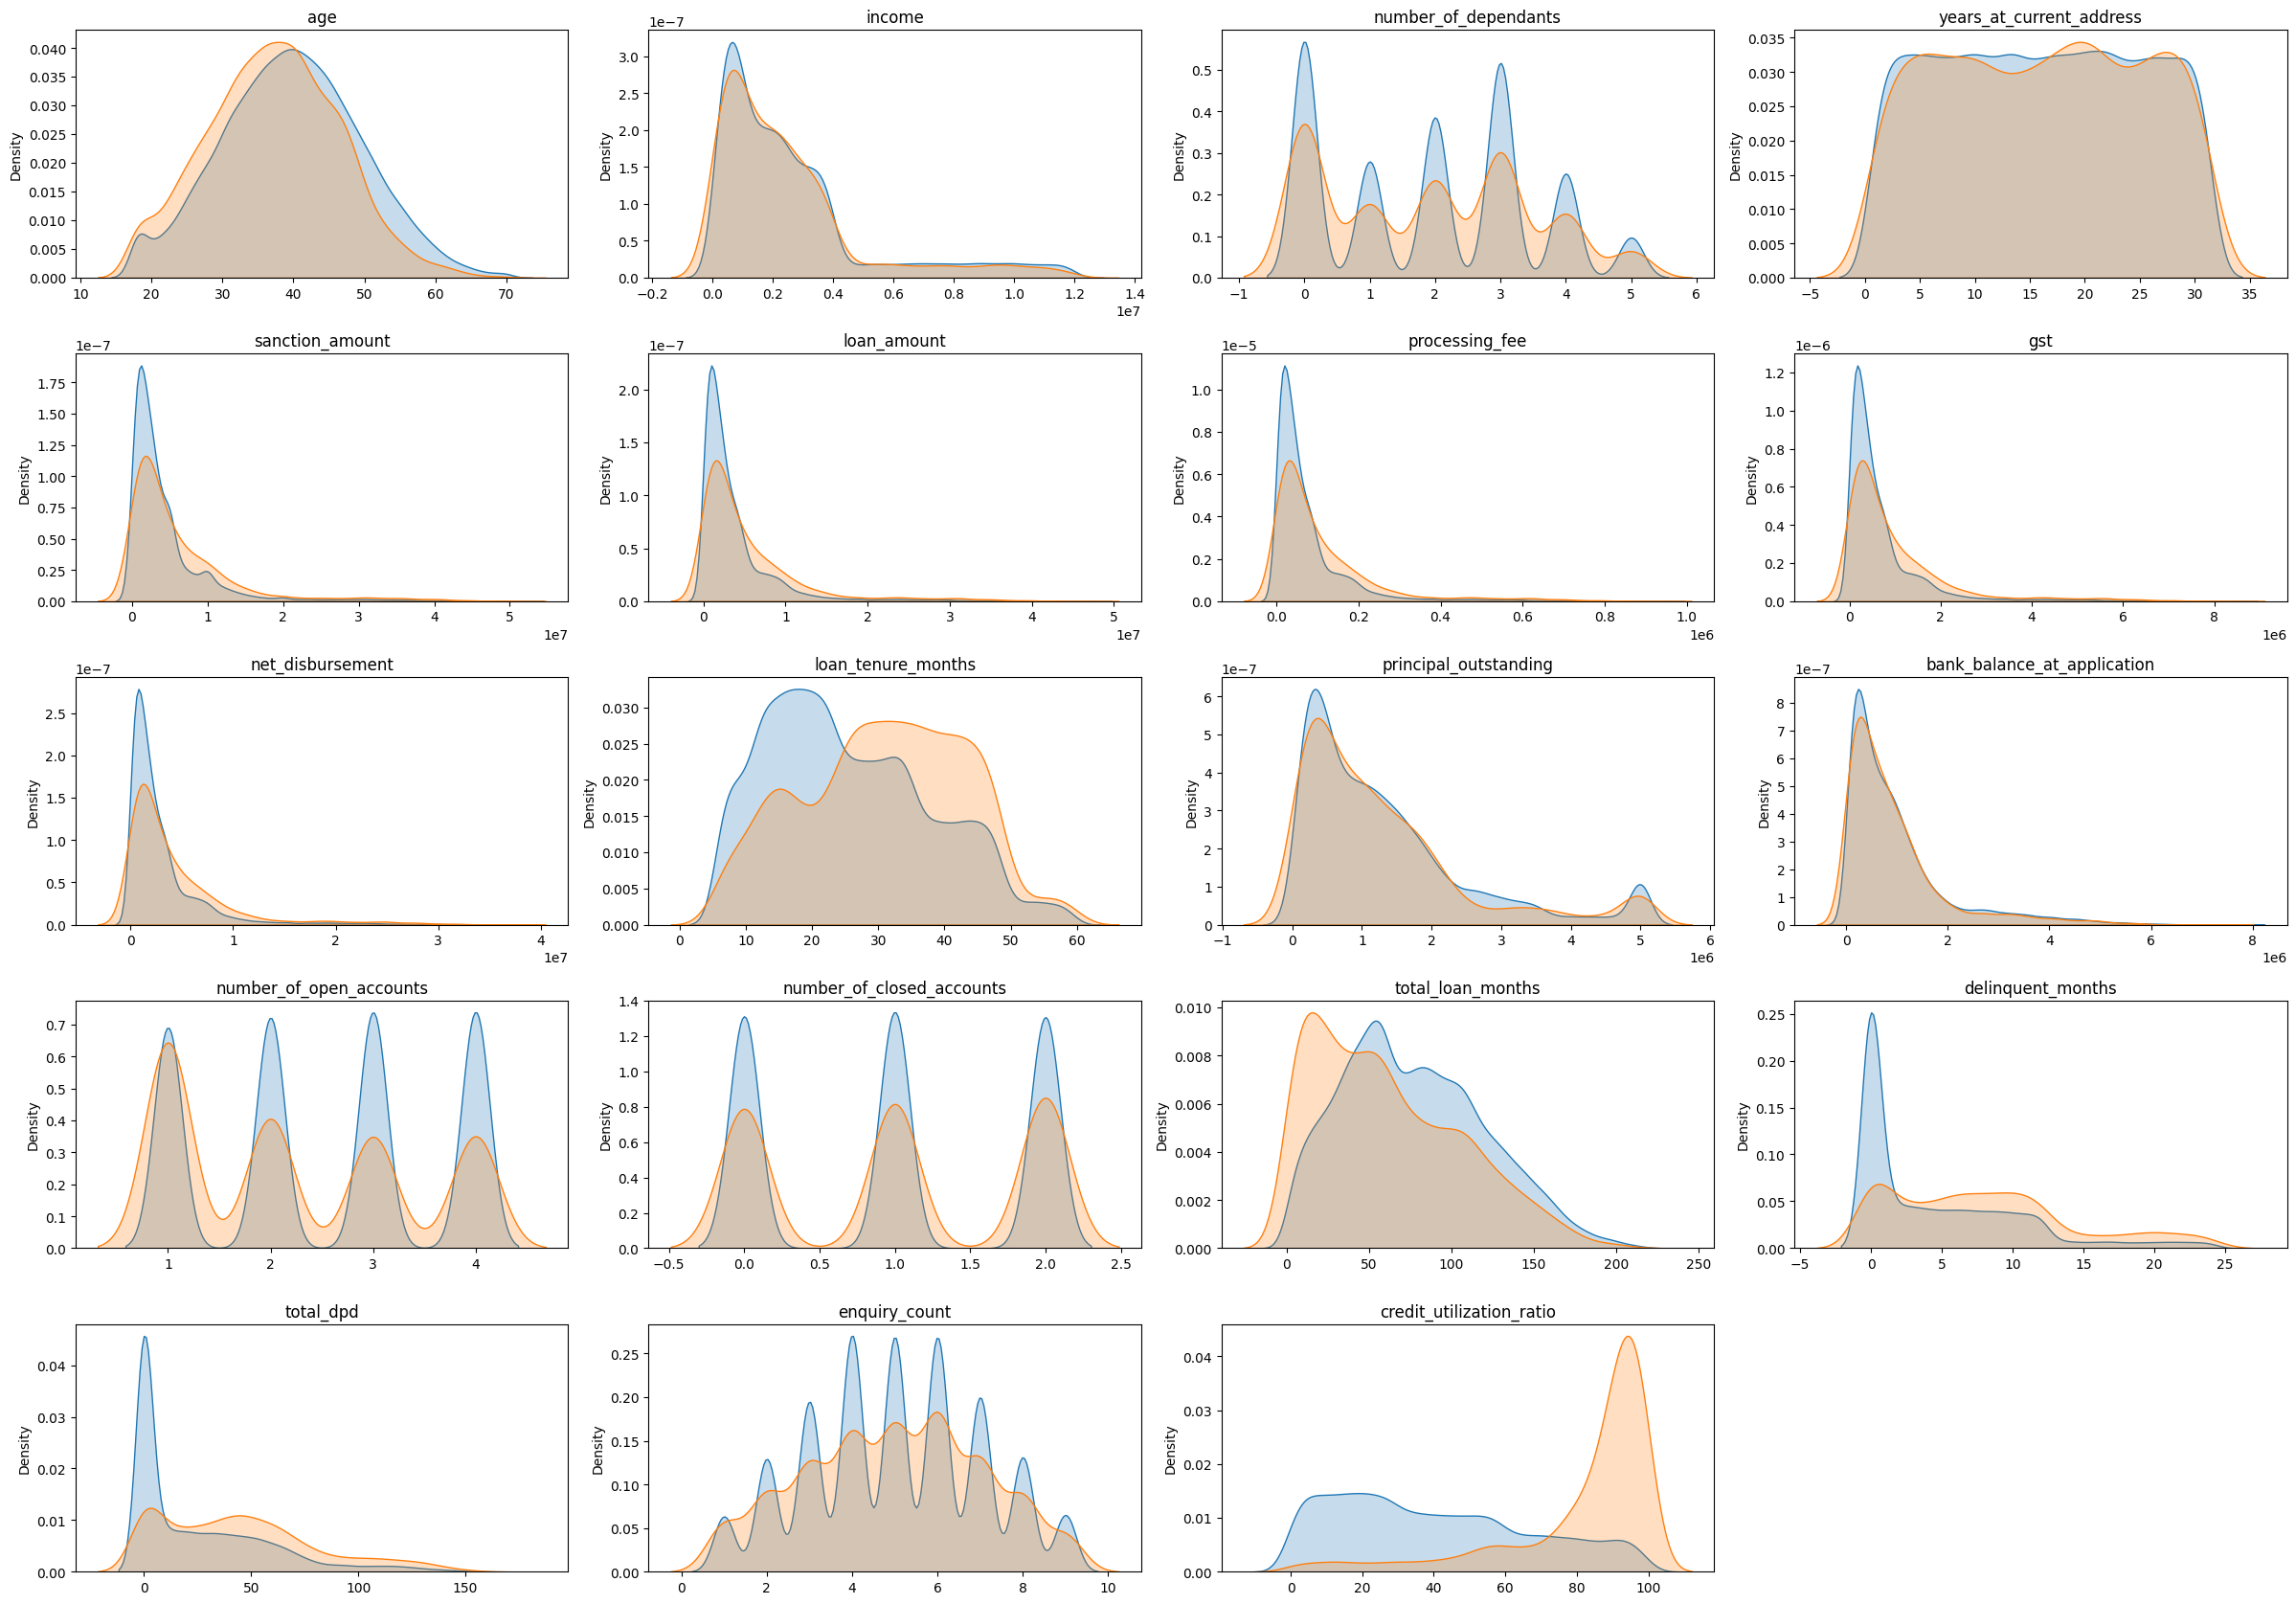

In [37]:
plt.figure(figsize=(24, 20))

for i, col in enumerate(columns_continuous):
    plt.subplot(6, 4, i+1)
    sns.kdeplot(df_train_1[col][df_train_1['default']==0], fill=True, label='default=0')
    sns.kdeplot(df_train_1[col][df_train_1['default']==1], fill=True, label='default=1')
    plt.title(col)        
    plt.xlabel('')
    
plt.tight_layout()
plt.show()

**Insights**

1. Higher values in the columns 'loan_tenure_months', 'delinquent_months', 'total_dpd', and 'credit_utilization' suggest an increased likelihood of default, making these four strong predictor variables.
2. The remaining columns do not reveal any clear insights based on their distributions.
3. Interestingly, 'loan_amount' and 'income' do not appear to be strong predictors on their own. However, combining these two to calculate the Loan-to-Income (LTI) ratio might provide better insights into their influence on the target variable. This will be explored further.

### **Feature engineering, feature selection**

#### Generate Loan to Income (LTI) ratio

In [38]:
df_train_1[["loan_amount", "income"]].head()

,loan_amount,income
12746,23442000,11327000
32495,1149000,715000
43675,11296000,3195000
9040,1695000,1500000
13077,905000,1817000


In [39]:
df_train_1['loan_to_income'] = round(df_train_1['loan_amount'] / df_train_1['income'],2)
df_train_1['loan_to_income'].describe()

count   37488.00
mean        1.56
std         0.97
min         0.30
25%         0.77
50%         1.16
75%         2.46
max         4.57
Name: loan_to_income, dtype: float64

In [40]:
df_test['loan_to_income'] = round(df_test['loan_amount'] / df_test['income'],2)

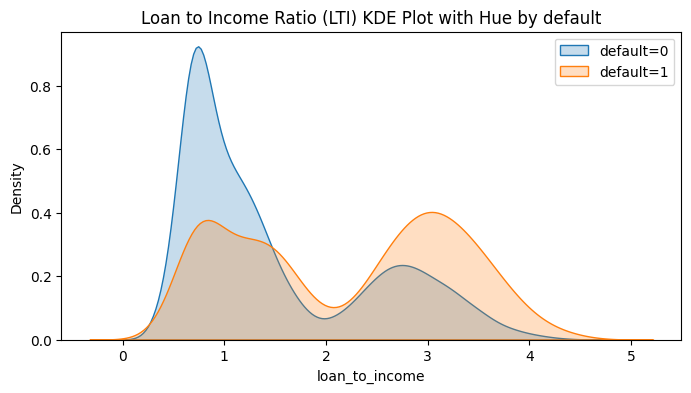

In [41]:
plt.figure(figsize=(8, 4))
sns.kdeplot(df_train_1['loan_to_income'][df_train_1['default'] == 0], fill=True, label='default=0')
sns.kdeplot(df_train_1['loan_to_income'][df_train_1['default'] == 1], fill=True, label='default=1')
plt.title(f"Loan to Income Ratio (LTI) KDE Plot with Hue by default")
plt.legend()
plt.show()

**Insights**
1. The blue graph predominantly shows values concentrated on the lower side of 'LTI'.
2. The orange graph displays a noticeable presence of higher 'LTI' values, suggesting that loans with a higher 'LTI' are associated with greater risk.

#### Generate delinquency ratio

In [42]:
df_train_1['delinquency_ratio'] = (df_train_1['delinquent_months']*100 / df_train_1['total_loan_months']).round(1)
df_test['delinquency_ratio'] = (df_test['delinquent_months']*100 / df_test['total_loan_months']).round(1)

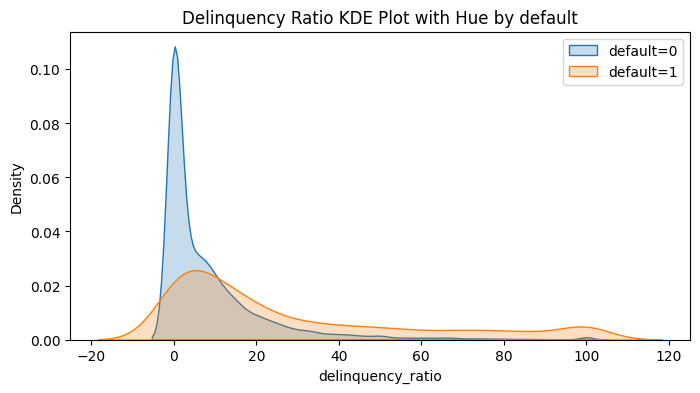

In [43]:
plt.figure(figsize=(8, 4))
sns.kdeplot(df_train_1['delinquency_ratio'][df_train_1['default'] == 0], fill=True, label='default=0')
sns.kdeplot(df_train_1['delinquency_ratio'][df_train_1['default'] == 1], fill=True, label='default=1')
plt.title(f"Delinquency Ratio KDE Plot with Hue by default")
plt.legend()
plt.show()

**Insights**
1. The blue graph predominantly shows values concentrated on the lower side of 'LTI'.
2. The orange graph reveals a significant number of values corresponding to a higher 'delinquency_ratio', indicating a possible correlation with default.

#### Calculate the average 'DPD' (Days Past Due) for each level of delinquency

In [44]:
df_train_1['avg_dpd_per_delinquency'] = np.where(
    df_train_1['delinquent_months'] != 0,
    (df_train_1['total_dpd'] / df_train_1['delinquent_months']).round(1),
    0
)

df_test['avg_dpd_per_delinquency'] = np.where(
    df_test['delinquent_months'] != 0,
    (df_test['total_dpd'] / df_test['delinquent_months']).round(1),
    0
)

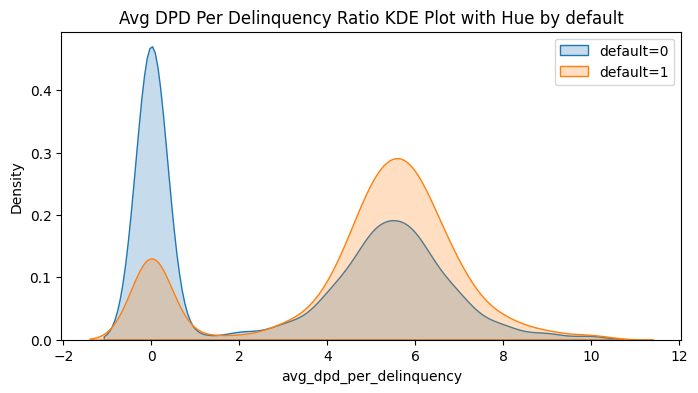

In [45]:
plt.figure(figsize=(8, 4))
sns.kdeplot(df_train_1['avg_dpd_per_delinquency'][df_train_1['default'] == 0], fill=True, label='default=0')
sns.kdeplot(df_train_1['avg_dpd_per_delinquency'][df_train_1['default'] == 1], fill=True, label='default=1')
plt.title(f"Avg DPD Per Delinquency Ratio KDE Plot with Hue by default")
plt.legend()
plt.show()

**Insights**
1. The graph clearly illustrates a higher frequency of default cases when 'avg_dpd_per_delinquency' is elevated, indicating that this column is a strong predictor of default.

#### Drop columns that serve as unique identifiers and do not contribute to predicting the target variable.

In [46]:
df_train_1.columns

Index(['cust_id', 'age', 'gender', 'marital_status', 'employment_status',
       'income', 'number_of_dependants', 'residence_type',
       'years_at_current_address', 'city', 'state', 'zipcode', 'loan_id',
       'loan_purpose', 'loan_type', 'sanction_amount', 'loan_amount',
       'processing_fee', 'gst', 'net_disbursement', 'loan_tenure_months',
       'principal_outstanding', 'bank_balance_at_application',
       'disbursal_date', 'installment_start_dt', 'number_of_open_accounts',
       'number_of_closed_accounts', 'total_loan_months', 'delinquent_months',
       'total_dpd', 'enquiry_count', 'credit_utilization_ratio', 'default',
       'loan_to_income', 'delinquency_ratio', 'avg_dpd_per_delinquency'],
      dtype='object')

In [47]:
df_train_2 = df_train_1.drop(['cust_id', 'loan_id'],axis="columns")
df_test = df_test.drop(['cust_id', 'loan_id'],axis="columns")

#### Drop the columns that the business contact person requested for removal.

In [48]:
df_train_3 = df_train_2.drop(['disbursal_date', 'installment_start_dt', 'loan_amount', 'income', 'total_loan_months', 'delinquent_months', 'total_dpd'], axis="columns")
df_test = df_test.drop(['disbursal_date', 'installment_start_dt', 'loan_amount', 'income', 'total_loan_months', 'delinquent_months', 'total_dpd'], axis="columns")
df_train_3.columns

Index(['age', 'gender', 'marital_status', 'employment_status',
       'number_of_dependants', 'residence_type', 'years_at_current_address',
       'city', 'state', 'zipcode', 'loan_purpose', 'loan_type',
       'sanction_amount', 'processing_fee', 'gst', 'net_disbursement',
       'loan_tenure_months', 'principal_outstanding',
       'bank_balance_at_application', 'number_of_open_accounts',
       'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'default', 'loan_to_income',
       'delinquency_ratio', 'avg_dpd_per_delinquency'],
      dtype='object')

In [49]:
df_train_3.select_dtypes(['int64', 'float64']).columns

Index(['age', 'number_of_dependants', 'years_at_current_address', 'zipcode',
       'sanction_amount', 'processing_fee', 'gst', 'net_disbursement',
       'loan_tenure_months', 'principal_outstanding',
       'bank_balance_at_application', 'number_of_open_accounts',
       'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency'],
      dtype='object')

#### Calculate Variance Inflation Factor (VIF) to assess multicollinearity 

In [50]:
X_train = df_train_3.drop('default', axis='columns')
y_train = df_train_3['default']

cols_to_scale = X_train.select_dtypes(['int64', 'float64']).columns

scaler = MinMaxScaler()

X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_train.describe()

,age,number_of_dependants,years_at_current_address,zipcode,sanction_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,number_of_open_accounts,number_of_closed_accounts,enquiry_count,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency
count,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00
mean,0.41,0.39,0.50,0.52,0.09,0.08,0.08,0.08,0.38,0.26,0.12,0.50,0.50,0.50,0.44,0.29,0.10,0.33
std,0.19,0.31,0.30,0.29,0.12,0.11,0.11,0.11,0.23,0.24,0.13,0.37,0.41,0.25,0.30,0.23,0.17,0.29
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.29,0.00,0.23,0.33,0.02,0.02,0.02,0.02,0.19,0.08,0.03,0.00,0.00,0.38,0.18,0.11,0.00,0.00
50%,0.40,0.40,0.50,0.49,0.05,0.05,0.05,0.05,0.34,0.19,0.08,0.67,0.50,0.50,0.39,0.20,0.04,0.43
75%,0.54,0.60,0.77,0.76,0.10,0.10,0.10,0.10,0.55,0.35,0.16,1.00,1.00,0.62,0.68,0.51,0.13,0.57
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [51]:
#Same transformation on test set
X_test = df_test.drop('default', axis='columns')
y_test = df_test['default']

X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
X_test.describe()

,age,number_of_dependants,years_at_current_address,zipcode,sanction_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,number_of_open_accounts,number_of_closed_accounts,enquiry_count,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency
count,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00
mean,0.42,0.38,0.50,0.53,0.09,0.08,0.08,0.08,0.38,0.26,0.12,0.50,0.50,0.50,0.44,0.29,0.11,0.33
std,0.19,0.31,0.30,0.29,0.12,0.11,0.11,0.11,0.23,0.25,0.13,0.37,0.41,0.25,0.30,0.23,0.17,0.29
min,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.29,0.00,0.23,0.33,0.02,0.02,0.02,0.02,0.19,0.08,0.03,0.00,0.00,0.38,0.18,0.11,0.00,0.00
50%,0.42,0.40,0.50,0.51,0.05,0.05,0.05,0.05,0.34,0.20,0.08,0.33,0.50,0.50,0.39,0.20,0.04,0.44
75%,0.54,0.60,0.77,0.76,0.10,0.09,0.09,0.09,0.55,0.36,0.16,0.67,1.00,0.62,0.68,0.50,0.13,0.58
max,1.00,1.00,1.00,1.00,0.98,0.96,0.96,0.96,1.00,1.00,0.94,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [52]:
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [53]:
X_train.head()

,age,gender,marital_status,employment_status,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode,...,loan_tenure_months,principal_outstanding,bank_balance_at_application,number_of_open_accounts,number_of_closed_accounts,enquiry_count,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency
12746,0.79,M,Married,Self-Employed,0.60,Owned,0.97,Hyderabad,Telangana,0.66,...,0.42,1.00,0.61,1.00,1.00,0.38,0.36,0.41,0.13,0.59
32495,0.50,F,Single,Salaried,0.00,Owned,0.87,Mumbai,Maharashtra,0.49,...,0.83,0.09,0.03,0.67,0.50,0.50,0.05,0.31,0.06,0.62
43675,0.38,M,Single,Salaried,0.00,Mortgage,0.83,Chennai,Tamil Nadu,0.83,...,0.49,0.33,0.17,0.00,0.50,0.38,0.00,0.76,0.22,0.56
9040,0.46,M,Married,Salaried,0.40,Mortgage,0.97,Bangalore,Karnataka,0.76,...,0.64,0.20,0.08,0.67,0.00,0.88,0.88,0.19,0.00,0.00
13077,0.77,M,Married,Self-Employed,0.80,Owned,0.93,Pune,Maharashtra,0.51,...,0.17,0.12,0.07,0.00,1.00,0.00,0.72,0.05,0.00,0.00


In [54]:
calculate_vif(X_train[cols_to_scale])

c:\Users\rajat\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Column,VIF
0,age,5.70
1,number_of_dependants,2.73
2,years_at_current_address,3.42
3,zipcode,3.80
4,sanction_amount,101.09
5,processing_fee,inf
6,gst,inf
7,net_disbursement,inf
8,loan_tenure_months,6.18
9,principal_outstanding,16.33


In [55]:
features_to_drop_vif = ['sanction_amount', 'processing_fee', 'gst', 'net_disbursement','principal_outstanding']

In [56]:
X_train_1 = X_train.drop(features_to_drop_vif, axis='columns')
numeric_columns = X_train_1.select_dtypes(['int64', 'float64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'years_at_current_address', 'zipcode',
       'loan_tenure_months', 'bank_balance_at_application',
       'number_of_open_accounts', 'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency'],
      dtype='object')

In [57]:
vif_df = calculate_vif(X_train_1[numeric_columns])
vif_df

,Column,VIF
0,age,5.43
1,number_of_dependants,2.73
2,years_at_current_address,3.40
3,zipcode,3.78
4,loan_tenure_months,6.02
5,bank_balance_at_application,1.80
6,number_of_open_accounts,4.35
7,number_of_closed_accounts,2.37
8,enquiry_count,6.38
9,credit_utilization_ratio,2.92


In [58]:
selected_numeric_features_vif = vif_df.Column.values
selected_numeric_features_vif

array(['age', 'number_of_dependants', 'years_at_current_address',
       'zipcode', 'loan_tenure_months', 'bank_balance_at_application',
       'number_of_open_accounts', 'number_of_closed_accounts',
       'enquiry_count', 'credit_utilization_ratio', 'loan_to_income',
       'delinquency_ratio', 'avg_dpd_per_delinquency'], dtype=object)

In [59]:
numeric_columns

Index(['age', 'number_of_dependants', 'years_at_current_address', 'zipcode',
       'loan_tenure_months', 'bank_balance_at_application',
       'number_of_open_accounts', 'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency'],
      dtype='object')

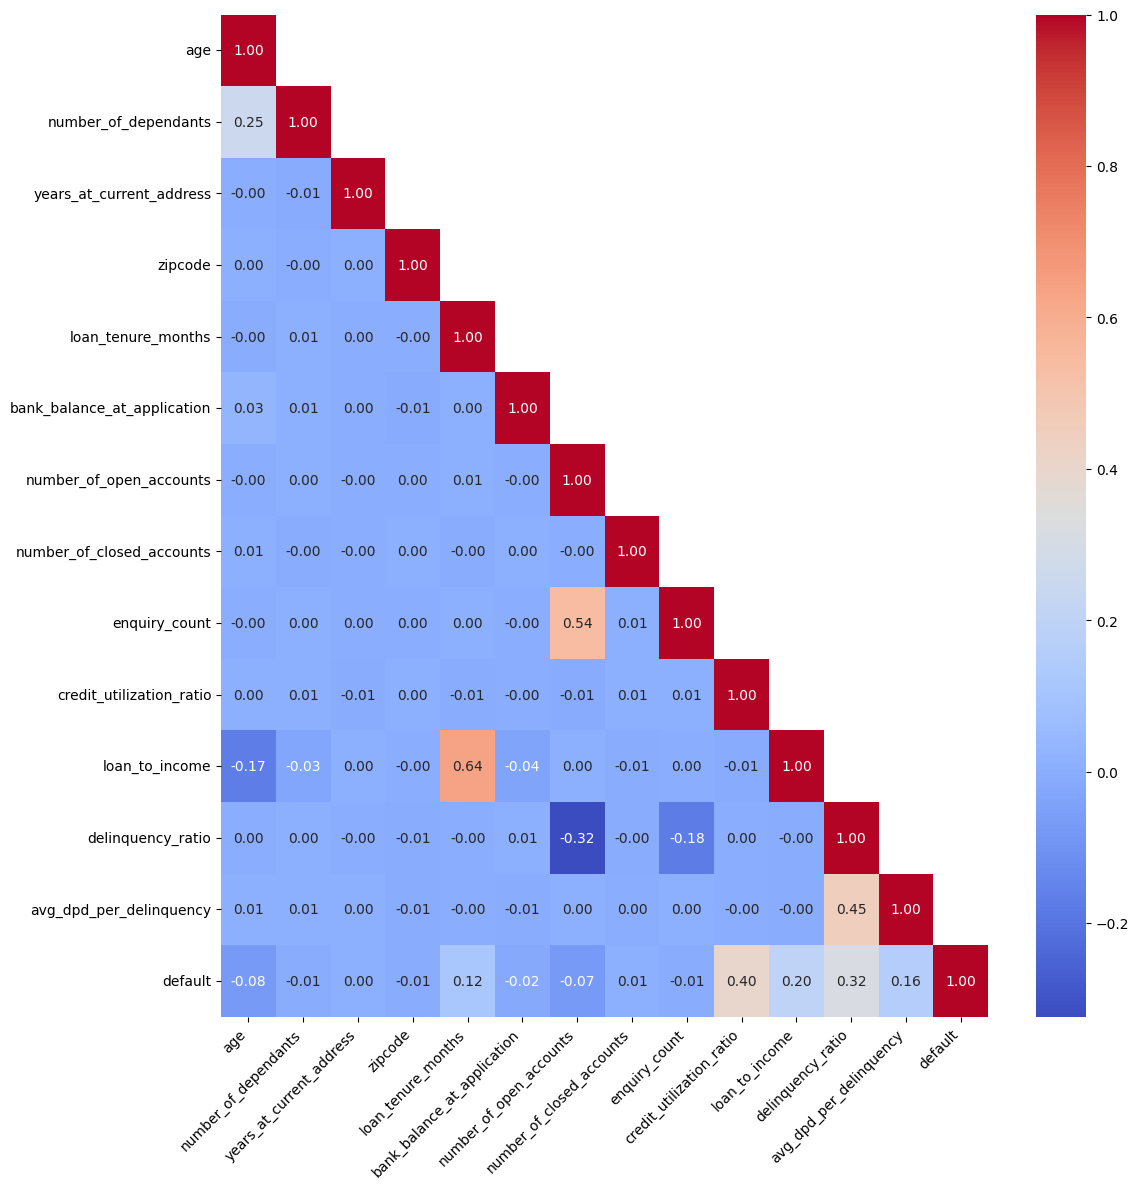

In [60]:
plt.figure(figsize=(12, 12))
cm = df_train_3[numeric_columns.append(pd.Index(['default']))].corr()
mask = np.triu(np.ones_like(cm, dtype=bool), k=1)
sns.heatmap(cm, mask=mask, annot=True, fmt='0.2f', cmap='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Feature selection: categorical features

In [61]:
X_train_1.head()

,age,gender,marital_status,employment_status,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode,...,loan_type,loan_tenure_months,bank_balance_at_application,number_of_open_accounts,number_of_closed_accounts,enquiry_count,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency
12746,0.79,M,Married,Self-Employed,0.60,Owned,0.97,Hyderabad,Telangana,0.66,...,Secured,0.42,0.61,1.00,1.00,0.38,0.36,0.41,0.13,0.59
32495,0.50,F,Single,Salaried,0.00,Owned,0.87,Mumbai,Maharashtra,0.49,...,Secured,0.83,0.03,0.67,0.50,0.50,0.05,0.31,0.06,0.62
43675,0.38,M,Single,Salaried,0.00,Mortgage,0.83,Chennai,Tamil Nadu,0.83,...,Secured,0.49,0.17,0.00,0.50,0.38,0.00,0.76,0.22,0.56
9040,0.46,M,Married,Salaried,0.40,Mortgage,0.97,Bangalore,Karnataka,0.76,...,Secured,0.64,0.08,0.67,0.00,0.88,0.88,0.19,0.00,0.00
13077,0.77,M,Married,Self-Employed,0.80,Owned,0.93,Pune,Maharashtra,0.51,...,Unsecured,0.17,0.07,0.00,1.00,0.00,0.72,0.05,0.00,0.00


#### Compute the Weight of Evidence (WOE) and Information Value (IV) to evaluate the predictive power of the features.

In [62]:
def calculate_woe_iv(df, feature, target):
    grouped = df.groupby(feature)[target].agg(['count','sum'])
    grouped = grouped.rename(columns={'count': 'total', 'sum': 'good'})
    grouped['bad']=grouped['total']-grouped['good']
    
    total_good = grouped['good'].sum()
    total_bad = grouped['bad'].sum()
    
    grouped['good_pct'] = grouped['good'] / total_good
    grouped['bad_pct'] = grouped['bad'] / total_bad
    grouped['woe'] = np.log(grouped['good_pct']/ grouped['bad_pct'])
    grouped['iv'] = (grouped['good_pct'] -grouped['bad_pct'])*grouped['woe']
    
    grouped['woe'] = grouped['woe'].replace([np.inf, -np.inf], 0)
    grouped['iv'] = grouped['iv'].replace([np.inf, -np.inf], 0)
    
    total_iv = grouped['iv'].sum()
    
    return grouped, total_iv

grouped, total_iv = calculate_woe_iv(pd.concat([X_train_1, y_train],axis=1), 'loan_purpose', 'default')
grouped

,total,good,bad,good_pct,bad_pct,woe,iv
loan_purpose,,,,,,,
Auto,7447,327,7120,0.10,0.21,-0.72,0.08
Education,5620,559,5061,0.17,0.15,0.16,0.00
Home,11304,1734,9570,0.54,0.28,0.66,0.17
Personal,13117,603,12514,0.19,0.37,-0.67,0.12


In [63]:
X_train_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37488 entries, 12746 to 37784
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          37488 non-null  float64
 1   gender                       37488 non-null  object 
 2   marital_status               37488 non-null  object 
 3   employment_status            37488 non-null  object 
 4   number_of_dependants         37488 non-null  float64
 5   residence_type               37488 non-null  object 
 6   years_at_current_address     37488 non-null  float64
 7   city                         37488 non-null  object 
 8   state                        37488 non-null  object 
 9   zipcode                      37488 non-null  float64
 10  loan_purpose                 37488 non-null  object 
 11  loan_type                    37488 non-null  object 
 12  loan_tenure_months           37488 non-null  float64
 13  bank_balance

In [64]:
iv_values = {}

for feature in X_train_1.columns:
    if X_train_1[feature].dtype == 'object':
        _, iv = calculate_woe_iv(pd.concat([X_train_1, y_train],axis=1), feature, 'default' )
    else:
        X_binned = pd.cut(X_train_1[feature], bins=10, labels=False)
        _, iv = calculate_woe_iv(pd.concat([X_binned, y_train],axis=1), feature, 'default' )
    iv_values[feature] = iv
        
iv_values

{'age': 0.0890689462679479,
 'gender': 0.00047449502170914947,
 'marital_status': 0.001129766845390142,
 'employment_status': 0.003953046301722585,
 'number_of_dependants': 0.0019380899135053508,
 'residence_type': 0.246745268718145,
 'years_at_current_address': 0.0020800513608156363,
 'city': 0.0019059578709781529,
 'state': 0.0019005589806779287,
 'zipcode': 0.0016677413243392572,
 'loan_purpose': 0.3691197842282755,
 'loan_type': 0.16319324904149224,
 'loan_tenure_months': 0.21893515090196278,
 'bank_balance_at_application': 0.0063187993277516365,
 'number_of_open_accounts': 0.08463134083005877,
 'number_of_closed_accounts': 0.0011964272592421567,
 'enquiry_count': 0.007864214085342608,
 'credit_utilization_ratio': 2.352965568168245,
 'loan_to_income': 0.476415456948364,
 'delinquency_ratio': 0.716576108689321,
 'avg_dpd_per_delinquency': 0.40151905412190175}

In [65]:
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

iv_df = pd.DataFrame(list(iv_values.items()), columns=['Feature', 'IV'])
iv_df = iv_df.sort_values(by='IV', ascending=False)
iv_df

,Feature,IV
17,credit_utilization_ratio,2.353
19,delinquency_ratio,0.717
18,loan_to_income,0.476
20,avg_dpd_per_delinquency,0.402
10,loan_purpose,0.369
5,residence_type,0.247
12,loan_tenure_months,0.219
11,loan_type,0.163
0,age,0.089
14,number_of_open_accounts,0.085


In [66]:
# Select features with an IV greater than 0.02
selected_features_iv = [feature for feature, iv in iv_values.items() if iv > 0.02]
selected_features_iv

['age',
 'residence_type',
 'loan_purpose',
 'loan_type',
 'loan_tenure_months',
 'number_of_open_accounts',
 'credit_utilization_ratio',
 'loan_to_income',
 'delinquency_ratio',
 'avg_dpd_per_delinquency']

#### Feature encoding

In [67]:
X_train_reduced = X_train_1[selected_features_iv]
X_test_reduced = X_test[selected_features_iv]

In [68]:
X_train_encoded = pd.get_dummies(X_train_reduced, drop_first=True)
X_train_encoded.head()

,age,loan_tenure_months,number_of_open_accounts,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency,residence_type_Owned,residence_type_Rented,loan_purpose_Education,loan_purpose_Home,loan_purpose_Personal,loan_type_Unsecured
12746,0.788,0.415,1.000,0.364,0.415,0.132,0.590,1,0,0,1,0,0
32495,0.500,0.830,0.667,0.051,0.307,0.062,0.620,1,0,1,0,0,0
43675,0.385,0.491,0.000,0.000,0.759,0.222,0.560,0,0,0,1,0,0
9040,0.462,0.642,0.667,0.879,0.194,0.000,0.000,0,0,1,0,0,0
13077,0.769,0.170,0.000,0.717,0.047,0.000,0.000,1,0,0,0,1,1


In [69]:
X_test_encoded = pd.get_dummies(X_test_reduced, drop_first=True)
X_test_encoded.head()

,age,loan_tenure_months,number_of_open_accounts,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency,residence_type_Owned,residence_type_Rented,loan_purpose_Education,loan_purpose_Home,loan_purpose_Personal,loan_type_Unsecured
19205,0.346,0.755,0.333,0.990,0.550,0.000,0.000,1,0,0,1,0,0
15514,0.481,0.226,1.000,0.323,0.220,0.000,0.000,1,0,1,0,0,0
30367,0.231,0.547,0.667,0.828,0.180,0.000,0.000,1,0,0,0,0,0
35347,0.365,0.755,1.000,0.485,0.571,0.024,0.700,1,0,0,1,0,0
41814,0.577,0.717,0.667,0.980,0.407,0.107,0.640,0,0,0,1,0,0


### **Model training**

**Attempt 1**

1. Models used: Logistic Regression, RandomForest, and XGBoost.
2. No specific techniques were applied to address class imbalance.

In [70]:
model = LogisticRegression()
model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11423
           1       0.84      0.72      0.78      1074

    accuracy                           0.96     12497
   macro avg       0.91      0.85      0.88     12497
weighted avg       0.96      0.96      0.96     12497



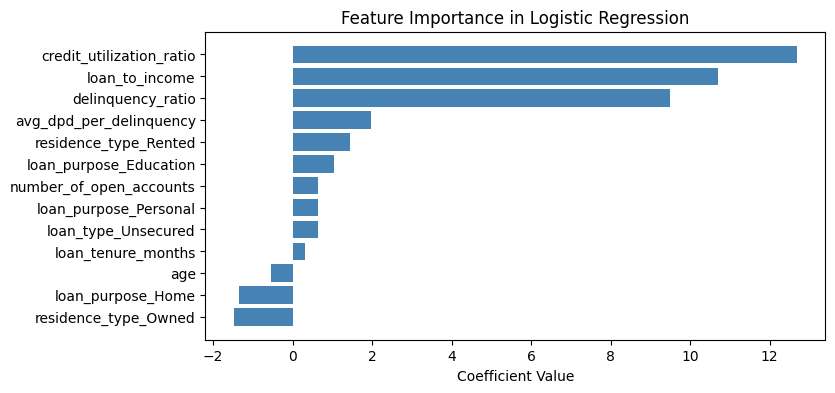

In [71]:
feature_importance = model.coef_[0]

coef_df = pd.DataFrame(feature_importance, index=X_train_encoded.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Logistic Regression')
plt.show()

In [72]:
model = RandomForestClassifier()
model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11423
           1       0.86      0.71      0.78      1074

    accuracy                           0.97     12497
   macro avg       0.92      0.85      0.88     12497
weighted avg       0.96      0.97      0.96     12497



In [73]:
model = XGBClassifier()
model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11423
           1       0.82      0.76      0.79      1074

    accuracy                           0.96     12497
   macro avg       0.90      0.87      0.88     12497
weighted avg       0.96      0.96      0.96     12497



Since the performance difference between XGBoost and Logistic Regression is minimal, we will select Logistic Regression for our RandomizedSearchCV candidate due to its better interpretability.

#### Perform RandomizedSearchCV for Attempt 1 using Logistic Regression to optimize hyperparameters and improve model performance.

In [74]:
param_dist = {
    'C': np.logspace(-4, 4, 20),
    'solver': ['lbfgs', 'saga', 'liblinear', 'newton-cg']
}

log_reg = LogisticRegression(max_iter=10000)

random_search = RandomizedSearchCV(LogisticRegression(max_iter=10000), {'C': np.logspace(-4, 4, 20), 'solver': ['lbfgs', 'saga', 'liblinear', 'newton-cg']}, n_iter=50, scoring='f1', cv=3, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train_encoded, y_train)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_encoded)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'solver': 'liblinear', 'C': 1438.44988828766}
Best Score: 0.7578820896729831
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     11423
           1       0.83      0.74      0.78      1074

    accuracy                           0.96     12497
   macro avg       0.90      0.86      0.88     12497
weighted avg       0.96      0.96      0.96     12497



#### Perform RandomizedSearchCV for Attempt 1 using XGBoost

In [75]:
param_dist = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'scale_pos_weight': [1, 2, 3, 5, 7, 10],
    'reg_alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0], 
    'reg_lambda': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]
}

xgb = XGBClassifier()

random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=100, scoring='f1', cv=3, verbose=1, n_jobs=-1, random_state=42)

random_search.fit(X_train_encoded, y_train)


print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_encoded)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'subsample': 0.9, 'scale_pos_weight': 2, 'reg_lambda': 10.0, 'reg_alpha': 10.0, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Best Score: 0.7871111337608832
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11423
           1       0.78      0.82      0.80      1074

    accuracy                           0.96     12497
   macro avg       0.88      0.90      0.89     12497
weighted avg       0.97      0.96      0.96     12497



**Attempt 2**
1. Models used: Logistic Regression and XGBoost.
2. Class imbalance addressed using Under Sampling.

In [76]:
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_encoded, y_train)
y_train_res.value_counts()

0    3223
1    3223
Name: default, dtype: int64

In [77]:
model = LogisticRegression()
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     11423
           1       0.51      0.96      0.67      1074

    accuracy                           0.92     12497
   macro avg       0.75      0.93      0.81     12497
weighted avg       0.95      0.92      0.93     12497



In [78]:
model = XGBClassifier(**random_search.best_params_)
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     11423
           1       0.52      0.99      0.68      1074

    accuracy                           0.92     12497
   macro avg       0.76      0.95      0.82     12497
weighted avg       0.96      0.92      0.93     12497



**Attempt 3**
1. Model used: Logistic Regression.
2. Class imbalance handled using SMOTE Tomek.
3. Hyperparameter tuning performed with Optuna.

In [79]:
smt = SMOTETomek(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train_encoded, y_train)
y_train_smt.value_counts()

0    34195
1    34195
Name: default, dtype: int64

In [80]:
model = LogisticRegression()
model.fit(X_train_smt, y_train_smt)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     11423
           1       0.55      0.94      0.70      1074

    accuracy                           0.93     12497
   macro avg       0.77      0.94      0.83     12497
weighted avg       0.96      0.93      0.94     12497



In [81]:
def objective(trial):
    param = {
        'C': trial.suggest_float('C', 1e-4, 1e4, log=True),  # Logarithmically spaced values
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga', 'newton-cg']),  # Solvers
        'tol': trial.suggest_float('tol', 1e-6, 1e-1, log=True),  # Logarithmically spaced values for tolerance
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])  # Class weights
    }

    model = LogisticRegression(**param, max_iter=10000)
    
    f1_scorer = make_scorer(f1_score, average='macro')
    scores = cross_val_score(model, X_train_smt, y_train_smt, cv=3, scoring=f1_scorer, n_jobs=-1)
    
    return np.mean(scores)

In [82]:
study_logistic = optuna.create_study(direction='maximize')
study_logistic.optimize(objective, n_trials=50)

[I 2025-03-17 07:18:02,697] A new study created in memory with name: no-name-c083e742-9dcd-49f0-8f61-3debd0a5be07
[I 2025-03-17 07:18:04,072] Trial 0 finished with value: 0.9456501530935721 and parameters: {'C': 116.15796182237986, 'solver': 'newton-cg', 'tol': 0.0003279299991130121, 'class_weight': None}. Best is trial 0 with value: 0.9456501530935721.
[I 2025-03-17 07:18:04,611] Trial 1 finished with value: 0.9456354945573398 and parameters: {'C': 106.51067772181027, 'solver': 'lbfgs', 'tol': 3.597554271300299e-05, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9456501530935721.
[I 2025-03-17 07:18:05,606] Trial 2 finished with value: 0.9457947369713162 and parameters: {'C': 2.916379005224866, 'solver': 'newton-cg', 'tol': 0.0002132835105764371, 'class_weight': None}. Best is trial 2 with value: 0.9457947369713162.
[I 2025-03-17 07:18:06,638] Trial 3 finished with value: 0.9457800262814403 and parameters: {'C': 2.7503358970520977, 'solver': 'newton-cg', 'tol': 5.216247188

In [83]:
print('Best trial:')
trial = study_logistic.best_trial
print('  F1-score: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))
    
best_model_logistic = LogisticRegression(**study_logistic.best_params)
best_model_logistic.fit(X_train_smt, y_train_smt)

y_pred = best_model_logistic.predict(X_test_encoded)

report = classification_report(y_test, y_pred)
print(report)

Best trial:
  F1-score: 0.9458393058744435
  Params: 
    C: 4.2238192844496
    solver: saga
    tol: 0.00021003999483014036
    class_weight: balanced
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     11423
           1       0.56      0.94      0.70      1074

    accuracy                           0.93     12497
   macro avg       0.78      0.94      0.83     12497
weighted avg       0.96      0.93      0.94     12497



**Attempt 4**
1. Model used: XGBoost.
2. Class imbalance handled using SMOTE Tomek.
3. Hyperparameter tuning performed with Optuna.

In [84]:
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'verbosity': 0,
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10)
    }

    model = XGBClassifier(**param)
    
    f1_scorer = make_scorer(f1_score, average='macro')
    scores = cross_val_score(model, X_train_smt, y_train_smt, cv=3, scoring=f1_scorer, n_jobs=-1)
    
    return np.mean(scores)

In [85]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective, n_trials=50)

[I 2025-03-17 07:18:34,495] A new study created in memory with name: no-name-628cc9f7-0039-422d-9a5b-f835a0f81905
[I 2025-03-17 07:18:35,490] Trial 0 finished with value: 0.9431760193718944 and parameters: {'lambda': 9.156713869567216, 'alpha': 0.24589153303001243, 'subsample': 0.7988634086491074, 'colsample_bytree': 0.7398343316221684, 'max_depth': 5, 'eta': 0.09436062944949497, 'gamma': 8.93757000056764, 'scale_pos_weight': 9.66975564365316, 'min_child_weight': 10, 'max_delta_step': 0}. Best is trial 0 with value: 0.9431760193718944.
[I 2025-03-17 07:18:37,041] Trial 1 finished with value: 0.9740797193489966 and parameters: {'lambda': 0.002417160993208584, 'alpha': 0.014559100686437027, 'subsample': 0.948592172910545, 'colsample_bytree': 0.9319854341579448, 'max_depth': 10, 'eta': 0.1119803361203862, 'gamma': 2.266118577062468, 'scale_pos_weight': 2.662132037332, 'min_child_weight': 1, 'max_delta_step': 0}. Best is trial 1 with value: 0.9740797193489966.
[I 2025-03-17 07:18:37,945] T

In [86]:
print('Best trial:')
trial = study_xgb.best_trial
print('  F1-score: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))
    
best_params = study_xgb.best_params
best_model_xgb = XGBClassifier(**best_params)
best_model_xgb.fit(X_train_smt, y_train_smt)

y_pred = best_model_xgb.predict(X_test_encoded)

report = classification_report(y_test, y_pred)
print(report)

Best trial:
  F1-score: 0.9768774111461237
  Params: 
    lambda: 0.009918350983167155
    alpha: 0.18782475068910362
    subsample: 0.8201384057836991
    colsample_bytree: 0.859288955402532
    max_depth: 10
    eta: 0.1832970233154804
    gamma: 0.3619945445440825
    scale_pos_weight: 2.108289126895129
    min_child_weight: 4
    max_delta_step: 6
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     11423
           1       0.71      0.85      0.78      1074

    accuracy                           0.96     12497
   macro avg       0.85      0.91      0.88     12497
weighted avg       0.96      0.96      0.96     12497



### **Model evaluation: ROC/AUC**

In [87]:
y_pred = best_model_logistic.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     11423
           1       0.56      0.94      0.70      1074

    accuracy                           0.93     12497
   macro avg       0.78      0.94      0.83     12497
weighted avg       0.96      0.93      0.94     12497



In [88]:
probabilities = best_model_logistic.predict_proba(X_test_encoded)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

fpr[:5], tpr[:5], thresholds[:5]

(array([0.        , 0.        , 0.        , 0.00008754, 0.00008754]),
 array([0.        , 0.0009311 , 0.16014898, 0.16014898, 0.17690875]),
 array([       inf, 1.        , 0.99946658, 0.99945715, 0.99933449]))

In [89]:
area = auc(fpr, tpr)
area

0.983670356337821

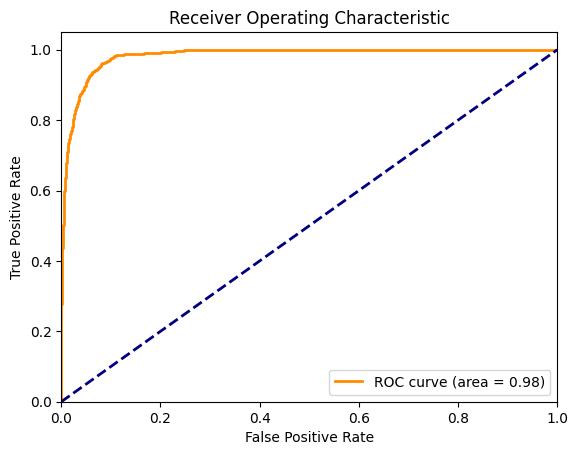

In [90]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### **Model Evaluation**

**Metrics used:**

1. Rank Ordering – Assessing the model's ability to differentiate between risk levels.
2. KS Statistic (Kolmogorov-Smirnov) – Measuring the model's discriminatory power.
3. Gini Coefficient – Evaluating the model's predictive accuracy.

In [91]:
probabilities = best_model_logistic.predict_proba(X_test_encoded)[:,1]

df_eval = pd.DataFrame({
    'Default Truth': y_test,
    'Default Probability': probabilities
})
df_eval.head()

,Default Truth,Default Probability
19205,0,0.531
15514,0,0.000
30367,0,0.006
35347,0,0.007
41814,1,0.921


In [92]:
df_eval['Decile'] = pd.qcut(df_eval['Default Probability'], 10, labels=False, duplicates='drop')
df_eval.head()

,Default Truth,Default Probability,Decile
19205,0,0.531,8
15514,0,0.000,2
30367,0,0.006,6
35347,0,0.007,6
41814,1,0.921,9


In [93]:
df_eval[df_eval.Decile==8]['Default Probability'].describe()

count   1250.000
mean       0.485
std        0.183
min        0.212
25%        0.316
50%        0.467
75%        0.641
max        0.820
Name: Default Probability, dtype: float64

In [94]:
df_decile = df_eval.groupby('Decile').apply(lambda x: pd.Series({
    'Minimum Probability': x['Default Probability'].min(),
    'Maximum Probability': x['Default Probability'].max(),
    'Events': x['Default Truth'].sum(),
    'Non-events': x['Default Truth'].count() - x['Default Truth'].sum(),    
}))
df_decile.reset_index(inplace=True)
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events
0,0,0.000,0.000,0.000,1250.000
1,1,0.000,0.000,0.000,1250.000
2,2,0.000,0.000,0.000,1249.000
3,3,0.000,0.000,0.000,1250.000
4,4,0.000,0.001,0.000,1250.000
5,5,0.001,0.004,0.000,1249.000
6,6,0.004,0.029,5.000,1245.000
7,7,0.029,0.212,10.000,1239.000
8,8,0.212,0.820,160.000,1090.000
9,9,0.820,1.000,899.000,351.000


In [95]:
df_decile['Event Rate'] = df_decile['Events']*100 / (df_decile['Events']+df_decile['Non-events'])
df_decile['Non-event Rate'] = df_decile['Non-events']*100 / (df_decile['Events']+df_decile['Non-events'])
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate
0,0,0.000,0.000,0.000,1250.000,0.000,100.000
1,1,0.000,0.000,0.000,1250.000,0.000,100.000
2,2,0.000,0.000,0.000,1249.000,0.000,100.000
3,3,0.000,0.000,0.000,1250.000,0.000,100.000
4,4,0.000,0.001,0.000,1250.000,0.000,100.000
5,5,0.001,0.004,0.000,1249.000,0.000,100.000
6,6,0.004,0.029,5.000,1245.000,0.400,99.600
7,7,0.029,0.212,10.000,1239.000,0.801,99.199
8,8,0.212,0.820,160.000,1090.000,12.800,87.200
9,9,0.820,1.000,899.000,351.000,71.920,28.080


In [96]:
df_decile = df_decile.sort_values(by='Decile', ascending=False).reset_index(drop=True)
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate
0,9,0.820,1.000,899.000,351.000,71.920,28.080
1,8,0.212,0.820,160.000,1090.000,12.800,87.200
2,7,0.029,0.212,10.000,1239.000,0.801,99.199
3,6,0.004,0.029,5.000,1245.000,0.400,99.600
4,5,0.001,0.004,0.000,1249.000,0.000,100.000
5,4,0.000,0.001,0.000,1250.000,0.000,100.000
6,3,0.000,0.000,0.000,1250.000,0.000,100.000
7,2,0.000,0.000,0.000,1249.000,0.000,100.000
8,1,0.000,0.000,0.000,1250.000,0.000,100.000
9,0,0.000,0.000,0.000,1250.000,0.000,100.000


In [97]:
df_decile['Cum Events'] =  df_decile['Events'].cumsum()
df_decile['Cum Non-events'] =  df_decile['Non-events'].cumsum()
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate,Cum Events,Cum Non-events
0,9,0.820,1.000,899.000,351.000,71.920,28.080,899.000,351.000
1,8,0.212,0.820,160.000,1090.000,12.800,87.200,1059.000,1441.000
2,7,0.029,0.212,10.000,1239.000,0.801,99.199,1069.000,2680.000
3,6,0.004,0.029,5.000,1245.000,0.400,99.600,1074.000,3925.000
4,5,0.001,0.004,0.000,1249.000,0.000,100.000,1074.000,5174.000
5,4,0.000,0.001,0.000,1250.000,0.000,100.000,1074.000,6424.000
6,3,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,7674.000
7,2,0.000,0.000,0.000,1249.000,0.000,100.000,1074.000,8923.000
8,1,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,10173.000
9,0,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,11423.000


In [98]:
df_decile['Cum Event Rate'] = df_decile['Cum Events'] * 100 / df_decile['Events'].sum()
df_decile['Cum Non-event Rate'] = df_decile['Cum Non-events']*100 / df_decile['Non-events'].sum()
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate,Cum Events,Cum Non-events,Cum Event Rate,Cum Non-event Rate
0,9,0.820,1.000,899.000,351.000,71.920,28.080,899.000,351.000,83.706,3.073
1,8,0.212,0.820,160.000,1090.000,12.800,87.200,1059.000,1441.000,98.603,12.615
2,7,0.029,0.212,10.000,1239.000,0.801,99.199,1069.000,2680.000,99.534,23.461
3,6,0.004,0.029,5.000,1245.000,0.400,99.600,1074.000,3925.000,100.000,34.361
4,5,0.001,0.004,0.000,1249.000,0.000,100.000,1074.000,5174.000,100.000,45.295
5,4,0.000,0.001,0.000,1250.000,0.000,100.000,1074.000,6424.000,100.000,56.237
6,3,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,7674.000,100.000,67.180
7,2,0.000,0.000,0.000,1249.000,0.000,100.000,1074.000,8923.000,100.000,78.114
8,1,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,10173.000,100.000,89.057
9,0,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,11423.000,100.000,100.000


In [99]:
df_decile['KS'] = abs(df_decile['Cum Event Rate'] - df_decile['Cum Non-event Rate'])
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate,Cum Events,Cum Non-events,Cum Event Rate,Cum Non-event Rate,KS
0,9,0.820,1.000,899.000,351.000,71.920,28.080,899.000,351.000,83.706,3.073,80.633
1,8,0.212,0.820,160.000,1090.000,12.800,87.200,1059.000,1441.000,98.603,12.615,85.988
2,7,0.029,0.212,10.000,1239.000,0.801,99.199,1069.000,2680.000,99.534,23.461,76.073
3,6,0.004,0.029,5.000,1245.000,0.400,99.600,1074.000,3925.000,100.000,34.361,65.639
4,5,0.001,0.004,0.000,1249.000,0.000,100.000,1074.000,5174.000,100.000,45.295,54.705
5,4,0.000,0.001,0.000,1250.000,0.000,100.000,1074.000,6424.000,100.000,56.237,43.763
6,3,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,7674.000,100.000,67.180,32.820
7,2,0.000,0.000,0.000,1249.000,0.000,100.000,1074.000,8923.000,100.000,78.114,21.886
8,1,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,10173.000,100.000,89.057,10.943
9,0,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,11423.000,100.000,100.000,0.000


### **Insights from the Decile Table**

#### Top Deciles
- The **first decile (Decile 9)** shows a high event rate of **72.00%** and a non-event rate of **28.00%**, indicating strong model confidence in predicting events within this decile.  
- The **second decile (Decile 8)** also reflects a notable event rate of **12.72%**, contributing to a cumulative event rate of **98.6%**.  

#### Middle Deciles
- **Deciles 7 and 6** demonstrate a noticeable decline in event rates.  

#### Lower Deciles
- **Deciles 5 to 0** report zero events, with a non-event rate of **100%**, indicating all predictions fall under non-events.  

#### KS Statistic
- The **KS statistic** reaches its peak at **Decile 8** with a value of **85.98%**, marking the point where the model effectively distinguishes between events and non-events.  
- The KS value gradually declines in subsequent deciles, signifying reduced model performance in differentiating between the two groups.  

#### Conclusion
- The highest **KS value** of **85.98%** at **Decile 8** indicates strong predictive performance.  
- Since the KS peak occurs within the **top three deciles** and exceeds **40%**, the model is considered to be a **good predictive model**.


In [100]:
gini_coefficient = 2 * area - 1

print("AUC:", area)
print("Gini Coefficient:", gini_coefficient)

AUC: 0.983670356337821
Gini Coefficient: 0.9673407126756419


**AUC (Area Under the Curve)**  
- An **AUC of 0.98** indicates that the model is highly effective in distinguishing between events and non-events, showcasing excellent predictive performance.  

**Gini Coefficient**  
- A **Gini coefficient of 0.96** further confirms the model's strong predictive capability, indicating near-perfect rank ordering.  
- The **Gini coefficient** ranges from **-1 to 1**:  
  - **1** indicates a **perfect model**  
  - **0** represents a model with **no discriminative power**  
  - **-1** signifies a **perfectly incorrect model**  


#### Finalize the model and visualize feature importance

In [101]:
final_model = best_model_logistic

feature_importance = final_model.coef_[0]

coef_df = pd.DataFrame(feature_importance, index=X_train_encoded.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

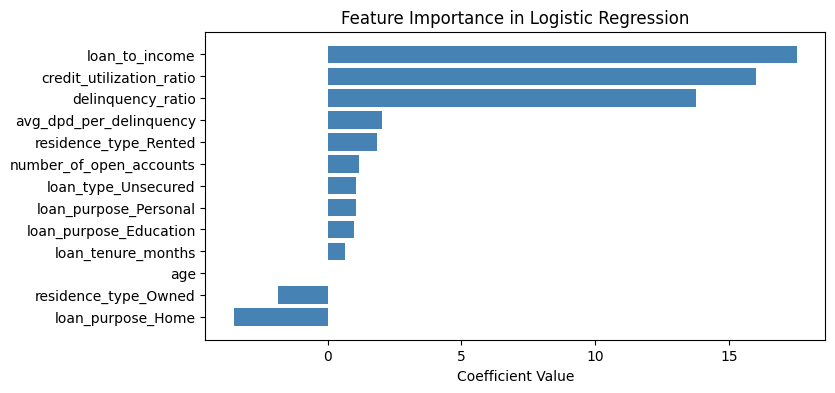

In [102]:
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Logistic Regression')
plt.show()

### **Save the model**

In [103]:
X_test_encoded.head()

,age,loan_tenure_months,number_of_open_accounts,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency,residence_type_Owned,residence_type_Rented,loan_purpose_Education,loan_purpose_Home,loan_purpose_Personal,loan_type_Unsecured
19205,0.346,0.755,0.333,0.990,0.550,0.000,0.000,1,0,0,1,0,0
15514,0.481,0.226,1.000,0.323,0.220,0.000,0.000,1,0,1,0,0,0
30367,0.231,0.547,0.667,0.828,0.180,0.000,0.000,1,0,0,0,0,0
35347,0.365,0.755,1.000,0.485,0.571,0.024,0.700,1,0,0,1,0,0
41814,0.577,0.717,0.667,0.980,0.407,0.107,0.640,0,0,0,1,0,0


In [104]:
X_test_encoded.columns

Index(['age', 'loan_tenure_months', 'number_of_open_accounts',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency', 'residence_type_Owned',
       'residence_type_Rented', 'loan_purpose_Education', 'loan_purpose_Home',
       'loan_purpose_Personal', 'loan_type_Unsecured'],
      dtype='object')

In [105]:
cols_to_scale

Index(['age', 'number_of_dependants', 'years_at_current_address', 'zipcode',
       'sanction_amount', 'processing_fee', 'gst', 'net_disbursement',
       'loan_tenure_months', 'principal_outstanding',
       'bank_balance_at_application', 'number_of_open_accounts',
       'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency'],
      dtype='object')

In [106]:
X_train_encoded.columns

Index(['age', 'loan_tenure_months', 'number_of_open_accounts',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency', 'residence_type_Owned',
       'residence_type_Rented', 'loan_purpose_Education', 'loan_purpose_Home',
       'loan_purpose_Personal', 'loan_type_Unsecured'],
      dtype='object')

In [107]:
model_data = {
    'model': final_model,
    'features': X_train_encoded.columns,
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}
dump(model_data, 'artifacts/model_data.joblib')

['artifacts/model_data.joblib']